In [0]:
import math
import io
import os
import operator
from timeit import default_timer as timer
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import tree
from tqdm import tqdm
import operator
import pandas as pd

from tensorflow.examples.tutorials.mnist import input_data




```
# This is formatted as code
```

## Restore Keras Model

In [0]:
# RUN ONCE
# Run Runtime->Reset ALl Runtimes to reset
!git clone https://github.com/mzweilin/EvadeML-Zoo
os.chdir('EvadeML-Zoo')

Cloning into 'EvadeML-Zoo'...
remote: Enumerating objects: 952, done.
remote: Total 952 (delta 0), reused 0 (delta 0), pack-reused 952
Receiving objects: 100% (952/952), 27.54 MiB | 17.33 MiB/s, done.
Resolving deltas: 100% (606/606), done.


In [0]:
mkdir downloads; curl -sL https://github.com/mzweilin/EvadeML-Zoo/releases/download/v0.1/downloads.tar.gz | tar xzv -C downloads

MagNet/
MagNet/defensive_models/
MagNet/defensive_models/MNIST_II
MagNet/defensive_models/MNIST_I
MagNet/defensive_models/CIFAR
trained_models/
trained_models/MNIST_pgdtrained.keras_weights.h5
trained_models/MNIST_pgdbase.keras_weights.h5
trained_models/CIFAR-10_carlini.keras_weights.h5
trained_models/MNIST_cleverhans.keras_weights.h5
trained_models/MNIST_cleverhans_adv_trained.keras_weights.h5
trained_models/MNIST_carlini.keras_weights.h5


In [0]:
from models import carlini_models
from keras.datasets import mnist as keras_mnist
from keras.utils import np_utils
from keras import backend as K


Using TensorFlow backend.


In [0]:
# Load MNIST data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
K.clear_session()
eml_carlini_mnist_model = carlini_models.carlini_mnist_model(logits=False, input_range_type=1)
eml_carlini_mnist_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

dataset_name = "MNIST"
model_name = "carlini"
model_weights_fpath = "%s_%s.keras_weights.h5" % (dataset_name, model_name)
model_weights_fpath = os.path.join('downloads/trained_models', model_weights_fpath)
eml_carlini_mnist_model.load_weights(model_weights_fpath)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
sess = K.get_session()
graph = sess.graph
t_image = graph.get_tensor_by_name('lambda_1_input:0')
t_prediction = graph.get_tensor_by_name('activation_7/Softmax:0')

t_layer = graph.get_tensor_by_name('activation_1/Relu:0')
t_layer = tf.nn.max_pool(t_layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
t_layer = tf.reshape(t_layer, [-1, 5408])
#t_layer = tf.nn.max_pool(t_layer, ksize=[1, 2, 2, 1])
#t_layer = graph.get_tensor_by_name('max_pooling2d_1/MaxPool:0')
#t_layer = tf.reshape(t_layer, [-1, 4608])
#t_layer = graph.get_tensor_by_name('activation_3/Relu:0')
#t_layer = tf.reshape(t_layer, [-1, 6400])
#t_layer = graph.get_tensor_by_name('activation_4/Relu:0')
#t_layer = tf.reshape(t_layer, [-1, 4096])
#t_layer = graph.get_tensor_by_name('flatten_1/Reshape:0')
#t_layer = graph.get_tensor_by_name('activation_5/Relu:0')
#t_layer = graph.get_tensor_by_name('activation_6/Relu:0')


In [0]:
def get_prediction(images, tensor=None, batch_size=100):
  images = np.reshape(images, [len(images), 28, 28, 1])
  if tensor is None:
    return eml_carlini_mnist_model.predict(images, batch_size=100)
  def get_prediction_batch(batch):
    feed = {t_image: np.array(batch)}
    return sess.run(tensor, feed_dict=feed)
  n = len(images)
  if n%batch_size == 0:
    batches = [images[i*batch_size:(i+1)*batch_size] for i in range(int(n/batch_size))]
  else:
    batches = [images[i*batch_size:(i+1)*batch_size] for i in range(int(n/batch_size) +1)]    
  batch_predictions = [get_prediction_batch(b) for b in tqdm(batches)]
  return np.concatenate(tuple(batch_predictions), axis=0)

def get_prediction2(t_inp, inps, t_out, batch_size=100):
  def get_prediction_batch(batch):
    feed = {t_inp: np.array(batch)}
    return sess.run(t_out, feed_dict=feed)
  n = len(inps)
  if n%batch_size == 0:
    batches = [inps[i*batch_size:(i+1)*batch_size] for i in range(int(n/batch_size))]
  else:
    batches = [inps[i*batch_size:(i+1)*batch_size] for i in range(int(n/batch_size) +1)]    
  batch_predictions = [get_prediction_batch(b) for b in batches]
  return np.concatenate(tuple(batch_predictions), axis=0)

In [0]:
# Evaluate model accuracy
test_predictions = get_prediction(mnist.test.images)
test_predictions = np.argmax(test_predictions, axis=1)
print "Test accuracy", 1.0*np.sum(test_predictions == mnist.test.labels)/len(mnist.test.images)

Test accuracy 0.9943


In [0]:
train_predictions_all = get_prediction(mnist.train.images)
train_predictions = np.argmax(train_predictions_all, axis=1)
print "Predictions computed for all training data"

test_predictions_all = get_prediction(mnist.test.images)
test_predictions = np.argmax(test_predictions_all, axis=1)
print "Predictions computed for all test data"

Predictions computed for all training data
Predictions computed for all test data


## Training an MNIST network (2 conv layers + 1 fully connected)

In [0]:
BATCH_SIZE = 50
TEST_BATCH_SIZE = 1000  
IMAGE_SIZE = 28
NUM_CLASSES = 10

In [0]:
mnist = input_data.read_data_sets('MNIST_data')

In [0]:
def weight_variable(shape, name):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name=name)

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name=name)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def create_model(fc1_dims=1024):
  x = tf.placeholder(tf.float32, shape=[None, 784], name='input')
  y_ = tf.placeholder(tf.float32, shape=[None, 10])

  W_conv1 = weight_variable([5, 5, 1, 32], 'w_conv1')
  b_conv1 = bias_variable([32], 'b_conv1')

  x_image = tf.reshape(x, [-1,28,28,1])
  h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
  h_pool1 = max_pool_2x2(h_conv1)
  h_pool1 = tf.identity(h_pool1, name="conv1")

  W_conv2 = weight_variable([5, 5, 32, 64], 'w_conv2')
  b_conv2 = bias_variable([64], 'b_conv2')

  h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
  h_pool2 = max_pool_2x2(h_conv2)
  h_pool2 = tf.identity(h_pool2, name="conv2")

  W_fc1 = weight_variable([7 * 7 * 64, fc1_dims], 'w_fc1')
  b_fc1 = bias_variable([fc1_dims], 'b_fc1')

  h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, name='fc1')

  keep_prob = tf.placeholder(tf.float32, name='keep_prob')
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  W_fc2 = weight_variable([fc1_dims, 10], 'w_fc2')
  b_fc2 = bias_variable([10], 'b_fc2')

  y_conv = tf.add(tf.matmul(h_fc1_drop, W_fc2), b_fc2, name='prediction')

  cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv))

  correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  return cross_entropy, accuracy, x, keep_prob, y_conv, y_


def create_ff_model(fc1_dims=800, fc2_dims=800, fc3_dims=800):
  x = tf.placeholder(tf.float32, shape=[None, 784], name='input')
  y_ = tf.placeholder(tf.float32, shape=[None, 10])
  keep_prob = tf.placeholder(tf.float32, name='keep_prob')

  W_fc1 = weight_variable([784, fc1_dims], 'w_fc1')
  b_fc1 = bias_variable([fc1_dims], 'b_fc1')
  h_fc1 = tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1, name='fc1')
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  W_fc2 = weight_variable([fc1_dims, fc2_dims], 'w_fc2')
  b_fc2 = bias_variable([fc2_dims], 'b_fc2')
  h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='fc2')
  h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

  W_fc3 = weight_variable([fc2_dims, fc3_dims], 'w_fc3')
  b_fc3 = bias_variable([fc3_dims], 'b_fc3')
  h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3, name='fc3')
  h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

  W_fc4 = weight_variable([fc3_dims, 10], 'w_fc4')
  b_fc4 = bias_variable([10], 'b_fc4')
  y_conv = tf.add(tf.matmul(h_fc3_drop, W_fc4), b_fc4, name='prediction')

  cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv))

  correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  return cross_entropy, accuracy, x, keep_prob, y_conv, y_

### Train a new model

In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
cross_entropy, accuracy, x, keep_prob, y_conv, y_ = create_ff_model(fc1_dims=800, fc2_dims=800, fc3_dims=800)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)
sess.run(tf.global_variables_initializer())
for i in range(0, 1200):
  batch = mnist.train.next_batch(BATCH_SIZE)
  train_step.run(feed_dict={x: batch[0], y_: np.eye(10)[batch[1]], keep_prob: 1.0})  # CHANGED DROPOUT
  if i%100 == 0:
    test_accuracy = accuracy.eval(feed_dict={
        x:mnist.test.images, y_: np.eye(10)[mnist.test.labels], keep_prob: 1.0})
    print("step %d, test accuracy %g"%(i, test_accuracy))    
ckpt_path_name = saver.save(sess, './checkpoints/mnist_invariant.ckpt', global_step=i)
print "Checkpoint saved at: %s" % ckpt_path_name

In [0]:
from google.colab import files
files.download(ckpt_path_name + '.data-00000-of-00001')
files.download(ckpt_path_name + '.index')
files.download(ckpt_path_name + '.meta')

### Restore a pretrained model

In [0]:
!mkdir -p ./checkpoints
!wget https://github.com/hayesconverse/sym_convnn/raw/master/MNIST_ITR_REL/MNIST_conv_checkpoint/mnist_invariants.ckpt.index -O ./checkpoints/mnist_invariants.ckpt.index
!wget https://github.com/hayesconverse/sym_convnn/raw/master/MNIST_ITR_REL/MNIST_conv_checkpoint/mnist_invariants.ckpt.meta -O ./checkpoints/mnist_invariants.ckpt.meta
!wget https://github.com/hayesconverse/sym_convnn/raw/master/MNIST_ITR_REL/MNIST_conv_checkpoint/mnist_invariants.ckpt.data-00000-of-00001 -O ./checkpoints/mnist_invariants.ckpt.data-00000-of-00001

--2018-12-04 20:53:13--  https://github.com/hayesconverse/sym_convnn/raw/master/MNIST_ITR_REL/MNIST_conv_checkpoint/mnist_invariants.ckpt.index
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hayesconverse/sym_convnn/master/MNIST_ITR_REL/MNIST_conv_checkpoint/mnist_invariants.ckpt.index [following]
--2018-12-04 20:53:13--  https://raw.githubusercontent.com/hayesconverse/sym_convnn/master/MNIST_ITR_REL/MNIST_conv_checkpoint/mnist_invariants.ckpt.index
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 903 [application/octet-stream]
Saving to: ‘./checkpoints/mnist_invariants.ckpt.index

In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
cross_entropy, accuracy, x, keep_prob, y_conv, y_ = create_model()
saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)
saver.restore(sess, './checkpoints/mnist_invariants.ckpt')

test_accuracy = accuracy.eval(feed_dict={
    x:mnist.test.images, y_: np.eye(10)[mnist.test.labels], keep_prob: 1.0})
print("Test accuracy %g"%(test_accuracy))    



INFO:tensorflow:Restoring parameters from ./checkpoints/mnist_invariants.ckpt
Test accuracy 0.9668


### Parameters of the network

In [0]:
w_fc1 = sess.run(sess.graph.get_tensor_by_name('w_fc1:0'))
b_fc1 = sess.run(sess.graph.get_tensor_by_name('b_fc1:0'))
print "FC1, weight and bias shape", w_fc1.shape, b_fc1.shape

w_fc2 = sess.run(sess.graph.get_tensor_by_name('w_fc2:0'))
b_fc2 = sess.run(sess.graph.get_tensor_by_name('b_fc2:0'))
print "FC2, weight and bias shape", w_fc2.shape, b_fc2.shape

w_conv1 = sess.run(sess.graph.get_tensor_by_name('w_conv1:0'))
b_conv1 = sess.run(sess.graph.get_tensor_by_name('b_conv1:0'))
print "Conv1, weight and bias shape", w_conv1.shape, b_conv1.shape

w_conv2 = sess.run(sess.graph.get_tensor_by_name('w_conv2:0'))
b_conv2 = sess.run(sess.graph.get_tensor_by_name('b_conv2:0'))
print "Conv2, weight and bias shape", w_conv2.shape, b_conv2.shape

FC1, weight and bias shape (3136, 1024) (1024,)
FC2, weight and bias shape (1024, 10) (10,)
Conv1, weight and bias shape (5, 5, 1, 32) (32,)
Conv2, weight and bias shape (5, 5, 32, 64) (64,)


## Library for IG Attribution and Conductance

In [0]:
y_conv = t_prediction
t_label = tf.placeholder(tf.int32)
t_neuron_id = tf.placeholder(tf.int32)
t_grad = tf.gradients(y_conv[:, t_label], t_image)
#t_fc1 = sess.graph.get_tensor_by_name('fc1:0')
t_layer = graph.get_tensor_by_name('flatten_1/Reshape:0')
#t_grad_neuron = tf.gradients(y_conv[:, t_label], t_fc1)[0]
#t_grad_conductance = tf.gradients(t_fc1[:,t_neuron_id], x, grad_ys=t_grad_neuron[:, t_neuron_id])
t_grad_layer = tf.gradients(y_conv[:, t_label], t_layer)[0]
t_grad_conductance = tf.gradients(t_layer[:, t_neuron_id], t_image, grad_ys=t_grad_layer[:, t_neuron_id])[0]

In [0]:
import copy

def attribute(inp, label, baseline=None, steps=50, use_top_label=False):
  def top_label(inp):
    return np.argmax(get_prediction([inp])[0])
  if baseline is None:
    baseline = 0*inp
  scaled_inputs = [baseline + (float(i)/steps)*(inp-baseline) for i in range(0, steps)]
  feed = {keep_prob:1.0}
  if use_top_label:
    feed[x] = [inp]
    logits = sess.run(y_conv, feed_dict=feed)[0]
    label = np.argmax(logits)
  feed[x] = scaled_inputs
  feed[t_label] = label
  grads, scores = sess.run([t_grad, y_conv], feed_dict=feed)  # shapes: <steps+1>, <steps+1, inp.shape>
  integrated_gradients = (inp-baseline)*np.average(grads[0], axis=0)  # shape: <inp.shape>
  print "FINAL SCORE", scores[-1][label]
  print "BASELINE SCORE", scores[0][label]
  print "SUM", np.sum(integrated_gradients), "DIFF", scores[-1][label] - scores[0][label]
  return integrated_gradients

def conductance(inp, label, neuron_id=None, baseline=None, steps=50):
  # neuron_id is the id of the neuron in layer t_fc1 through which conductance
  # must be computed. If None, vanilla IG is computed.
  if baseline is None:
    baseline = 0*inp
  scaled_inputs = [baseline + (float(i)/steps)*(inp-baseline) for i in range(0, steps)]
  feed = {keep_prob:1.0}
  feed[x] = scaled_inputs
  feed[t_label] = label
  if neuron_id != None:
    feed[t_neuron_id] = neuron_id
    grads, scores = sess.run([t_grad_conductance, y_conv], feed_dict=feed)  # shapes: <steps+1>, <steps+1, inp.shape>
    integrated_gradients = (inp-baseline)*np.average(grads[0], axis=0)  # shape: <inp.shape>
    return integrated_gradients
  grads, scores = sess.run([t_grad, y_conv], feed_dict=feed)  # shapes: <steps+1>, <steps+1, inp.shape>    
  integrated_gradients = (inp-baseline)*np.average(grads[0], axis=0)  # shape: <inp.shape>
  print "FINAL SCORE", scores[-1][label]
  print "BASELINE SCORE", scores[0][label]
  print "SUM", np.sum(integrated_gradients), "DIFF", scores[-1][label] - scores[0][label]
  return integrated_gradients


def all_conductances(inp, label, baseline=None, steps=20):
  # neuron_id is the id of the neuron in layer t_layer through which conductance
  # must be computed. If None, vanilla IG is computed.
  if baseline is None:
    baseline = 0*inp
  scaled_inputs = [baseline + (float(i)/steps)*(inp-baseline) for i in range(0, steps)]
  feed = {keep_prob:1.0}
  feed[x] = scaled_inputs
  feed[t_label] = label
  grads, layer = sess.run([t_grad_layer,  t_layer], feed_dict=feed)  # shapes: <steps+1, t_layer.shape[1:]>
  layer_steps = layer[1:, :] - layer[:-1, :]  # shape: <steps, t_layer.shape[1:]>
  conductances = np.sum(grads[:-1]*layer_steps, axis=0)
  return conductances


## Library for Visualizing Images and Attributions

In [0]:
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import numpy as np
from cStringIO import StringIO

In [0]:
FONT_PATH='/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed.ttf'
IMAGE_SIZE = 28

def mnist_to_rgb(mnist_img):
  """
  Transformsn an MNIST image (shape: <784>) to a grayscale
  RGB image (shape: <28,28,3>)
  """
  pixel_array = mnist_img.reshape(IMAGE_SIZE, IMAGE_SIZE)  # shape: 28,28
  rgb_image = np.transpose([pixel_array,pixel_array,pixel_array], axes=[1,2,0])
  return rgb_image

def pil_img(a):
  '''Returns a PIL image created from the provided RGB array.
  '''
  a = np.uint8(a)
  return PIL.Image.fromarray(a)

def mnist_to_pil_img(inp):
  rgb_inp = 255*mnist_to_rgb(inp)
  vis_inp = pil_img(rgb_inp)
  return vis_inp  

def pil_fig(fig):
  # Returns a PIL image obtained from the provided PLT figure.
  buf = io.BytesIO()
  fig.savefig(buf, format='png')
  plt.close(fig)
  buf.seek(0)
  img = PIL.Image.open(buf)
  return img

def show_img(img, fmt='jpeg'):
  '''Displays the provided PIL image
  '''
  f = StringIO()
  img.save(f, fmt)
  display(Image(data=f.getvalue()))
 
def show_mnist_img(mnist_img):
  show_img(pil_img(255*mnist_to_rgb(mnist_img)))
  
def gray_scale(img):
  '''Converts the provided RGB image to gray scale.
  '''
  img = np.average(img, axis=2)
  return np.transpose([img, img, img], axes=[1,2,0])

def normalize(attrs, ptile=99):
  '''Normalize the provided attributions so that they fall between
     -1.0 and 1.0.
  '''
  h = np.percentile(attrs, ptile)
  l = np.percentile(attrs, 100-ptile)
  return np.clip(attrs/max(abs(h), abs(l)), -1.0, 1.0)    

def pil_text(strs, shape, start_h=10, start_w=10, font_size=18, color=(0, 0, 0)):
  # Returns a PIL image with the provided text.
  img = pil_img(255*np.ones(shape))
  draw = PIL.ImageDraw.Draw(img)
  font = PIL.ImageFont.truetype(FONT_PATH, font_size)
  h = start_h
  for s in strs: 
    draw.text((start_w,h), s, fill=color, font=font)
    h = h + 30
  return img

def combine(imgs, horizontal=True):
  # Combines the provided PIL Images horizontally or veritically
  if horizontal:
    w = np.sum([img.size[0]+10 for img in imgs])
    h = np.max([img.size[1] for img in imgs])
  else:
    w = np.max([img.size[0] for img in imgs])
    h = np.sum([img.size[1]+10 for img in imgs])
  final_img = PIL.Image.new('RGB', (w, h), color='white')
  pos = 0
  for img in imgs:
    if horizontal:
      final_img.paste(im=img, box=(pos,0))
      pos = pos+img.size[0]+10
    else:
      final_img.paste(im=img, box=(0,pos))
      pos = pos+img.size[1]+10
  return final_img

def visualize_attrs(img, attrs, ptile=99):
  '''Visaualizes the provided attributions by first aggregating them
    along the color channel to obtain per-pixel attributions and then
    scaling the intensities of the pixels in the original image in
    proportion to absolute value of these attributions.

    The provided image and attributions must of shape (224, 224, 3).
  '''
  if np.sum(attrs) == 0.0:
    # print "Attributions are all ZERO"
    return pil_img(0*img)
  attrs = gray_scale(attrs)
  attrs = abs(attrs)
  attrs = np.clip(attrs/np.percentile(attrs, ptile), 0,1)
  vis = img*attrs
  return pil_img(vis)
  
  
R=np.array([255,0,0])
G=np.array([0,255,0])
B=np.array([0,0,255])
def visualize_attrs2(img, attrs, pos_ch=G, neg_ch=R, ptile=99):
  '''Visaualizes the provided attributions by first aggregating them
     along the color channel and then overlaying the positive attributions
     along pos_ch, and negative attributions along neg_ch.

     The provided image and attributions must of shape (224, 224, 3).
  '''
  if np.sum(attrs) == 0.0:
    # print "Attributions are all ZERO"
    return pil_img(0*img)
  attrs = gray_scale(attrs)
  attrs = normalize(attrs, ptile)   
  pos_attrs = attrs * (attrs >= 0.0)
  neg_attrs = -1.0 * attrs * (attrs < 0.0)
  attrs_mask = pos_attrs*pos_ch + neg_attrs*neg_ch
  vis = 0.3*gray_scale(img) + 0.7*attrs_mask
  return pil_img(vis)

## Wiggle Room Analysis

In [0]:
def get_wiggle_room(inp, pixel_id, n=100, max_rng=1.0, min_rng=0.0):
  def first_index_where_prediction_changes(batch):
    predictions = get_prediction(batch, tensor=t_fc1)
    ref_class = predictions[0]
    diff_indices = np.where(predictions != ref_class)[0]
    # assume that np.where returns indices in sorted order,
    # return the first index where the prediction class differs.
    if len(diff_indices) > 0:
     return diff_indices[0]
    return -1
  inp = copy.deepcopy(inp)
  hi_batch = [1.0*inp for _ in range(n)]
  for i in range(n):
    hi_batch[i][pixel_id] = inp[pixel_id] + (max_rng - inp[pixel_id])*float(i)/n
  hi = first_index_where_prediction_changes(hi_batch)
  print hi
  if hi == -1:
    hi = 256.0
  print hi
  hi = hi*(max_rng - inp[pixel_id])/n
  lo_batch = [1.0*inp for _ in range(n)]
  for i in range(n):
    lo_batch[i][pixel_id] = inp[pixel_id] + (min_rng - inp[pixel_id])*float(i)/n
  lo = first_index_where_prediction_changes(lo_batch)
  print lo
  if lo == -1:
    lo = 0.0
  lo = lo*(inp[pixel_id]-min_rng)/n
  return lo, hi, hi-lo

In [0]:
inp = copy.deepcopy(mnist.train.images[0])
get_wiggle_room(inp, pixel_id=100, n=100)

1
1
-1


(0.0, 0.01, 0.01)

In [0]:
inp = copy.deepcopy(mnist.train.images[0])
attrs = np.zeros(784)
for i in range(784):
  lo, hi = get_wiggle_room(inp, pixel_id=i, n=20)
  print i, lo, hi
  attrs[i] = 1.0/(hi - lo)
  if i % 50 == 0:
    print "Done with", i

## Extracting Invariant Candidates

In [0]:
#t_fc1 = sess.graph.get_tensor_by_name('fc1:0')
#t_fc2 = sess.graph.get_tensor_by_name('fc2:0')
#t_fc3 = sess.graph.get_tensor_by_name('fc3:0')
# t_layer = graph.get_tensor_by_name('flatten_1/Reshape:0')

# t_layer is defined right where the Keras model is defined
def fingerprint_suffix(images):
  print "Getting fingerprint for", t_layer.name
  # Below T_LAYER is the final fully connected layer of size 1024.
  return (get_prediction(images, tensor=t_layer)>0.0).astype('int')

In [0]:
# train_suffixes, train_predictions are in the same order
# as mnist.train.images. Henceforth when we use the index i we will
# be referring to mnist.train.images[i].
train_suffixes = fingerprint_suffix(mnist.train.images)
print "Suffixes computed for all training data"

  1%|          | 6/550 [00:00<00:09, 54.49it/s]

Getting fingerprint for Reshape_7:0


100%|██████████| 550/550 [00:08<00:00, 65.12it/s]


Suffixes computed for all training data


In [0]:
train_predictions_all = get_prediction(mnist.train.images)
train_predictions = np.argmax(train_predictions_all, axis=1)
print "Predictions computed for all training data"

Predictions computed for all training data


In [0]:
# test_suffixes, test_predictions are in the same order
# as mnist.train.images. Henceforth when we use the index i we will
# be referring to mnist.train.images[i].
test_suffixes = fingerprint_suffix(mnist.test.images)
print "Suffixes computed for all test data"

  6%|▌         | 6/100 [00:00<00:01, 52.52it/s]

Getting fingerprint for Reshape:0


100%|██████████| 100/100 [00:01<00:00, 54.55it/s]


Suffixes computed for all test data


In [0]:
test_predictions_all = get_prediction(mnist.test.images)
test_predictions = np.argmax(test_predictions_all, axis=1)
print "Predictions computed for all test data"

Predictions computed for all test data


In [0]:
def describe_input(i, training=True):
  print "Input", i
  print "Groundtruth", mnist.train.labels[i]
  print "Prediction", train_predictions[i]
  print "Fine-grained prediction", 10*mnist.train.labels[i] + train_predictions[i]
  show_mnist_img(mnist.train.images[i])

### Compute neuron importance

In [0]:
# Compute all conductances at t_layer for all inputs in the training set.
# SLOW; consider running the cell below.
train_all_conductances = [None for _ in mnist.train.images]
for i,inp in tqdm(enumerate(mnist.train.images)):
  train_all_conductances[i] = all_conductances(inp, train_predictions[i])
train_all_conductances = np.array(train_all_conductances)

In [0]:
# The prediction is a linear function of the layer t_fc1. Consequently the importance
# of each neuron in t_layer can be computed using the coefficients of this linear function, i.e., w_fc2.
# The importance of neuron i is the difference between max(w_fc2[i, :]) and min(w_fc2[i, :])
layer_imp = np.max(w_fc2, axis=1) - np.min(w_fc2, axis=1)
layer_imp.shape

(1024,)

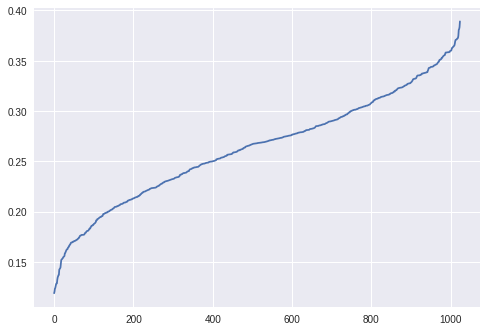

In [0]:
plt.plot(np.sort(layer_imp))

## Build the Decision Tree

In [0]:
# Basic decision tree
basic_estimator = tree.DecisionTreeClassifier()
basic_estimator.fit(train_suffixes, train_predictions)
print "Basic Estimator trained"
basic_estimator_acc = (basic_estimator.predict(test_suffixes) == mnist.test.labels)
basic_estimator_agreement = (basic_estimator.predict(test_suffixes) == test_predictions)
print "Estimator accuracy", 1.0*np.sum(basic_estimator_acc)/len(test_suffixes)
print "Estimator agreement", 1.0*np.sum(basic_estimator_agreement)/len(test_suffixes)

Basic Estimator trained
Estimator accuracy 0.8986
Estimator agreement 0.899


In [0]:
# Fine-grained predictions decision tree
fine_grained_predictions = 10*mnist.train.labels + train_predictions
fine_grained_estimator = tree.DecisionTreeClassifier()
fine_grained_estimator.fit(train_suffixes, fine_grained_predictions)
print "Fine-grained Estimator trained"

Fine-grained Estimator trained


In [0]:
# Decision tree per label
def get_relative_predictions(label):
  print "Create relative predictions for label:%d" % label
  res = np.zeros(train_predictions.shape)
  for i in range(len(train_predictions)):
    pred = train_predictions[i]
    gt = mnist.train.labels[i]
    if gt == label and pred == gt:
      res[i] = 0
    elif gt == label and pred != gt:
      res[i] = 1
    else:
      res[i] = 2
  print "Num correct: %d" % np.sum(res == 0)
  print "Num misclassified: %d" % np.sum(res == 1)
  print "Num others: %d" % np.sum(res == 2)
  return res

def get_relative_estimator(label):
  predictions = get_relative_predictions(label)
  print "Creating decision tree for label:%d" % label
  estimator = tree.DecisionTreeClassifier()
  estimator.fit(train_suffixes, predictions)
  return estimator

In [0]:
# SLOW; run only if you want to build relative estimators.
relative_estimators = [None for _ in range(10)]
for i in range(10):
  relative_estimators[i] = get_relative_estimator(i)

## Results for Paper (CAV 2019)

In [0]:
# Run Restore Keras Model and Jump to this place

In [0]:
train_predictions_all = get_prediction(mnist.train.images)
train_predictions = np.argmax(train_predictions_all, axis=1)
print "Predictions computed for all training data"

test_predictions_all = get_prediction(mnist.test.images)
test_predictions = np.argmax(test_predictions_all, axis=1)
print "Predictions computed for all test data"

validation_predictions_all = get_prediction(mnist.validation.images)
validation_predictions = np.argmax(validation_predictions_all, axis=1)
print "Predictions computed for all validation data"


Predictions computed for all training data
Predictions computed for all test data
Predictions computed for all validation data


In [0]:
# t_layer is defined right where the Keras model is defined
def fingerprint_suffix(images, tensor=t_layer):
  print "Getting fingerprint for", t_layer.name
  return (get_prediction(images, tensor=tensor)>0.0).astype('int')

#t_layer = graph.get_tensor_by_name('activation_3/Relu:0')
#t_layer = tf.reshape(t_layer, [-1, 6400])
#t_layer = graph.get_tensor_by_name('activation_4/Relu:0')
#t_layer = tf.reshape(t_layer, [-1, 4096])
#t_layer = graph.get_tensor_by_name('flatten_1/Reshape:0')

t_maxpool1 = graph.get_tensor_by_name('max_pooling2d_1/MaxPool:0')
t_maxpool1_rs = tf.reshape(t_maxpool1, [-1, 4608])
train_suffixes_maxpool1 = fingerprint_suffix(mnist.train.images, tensor=t_maxpool1_rs)
test_suffixes_maxpool1 = fingerprint_suffix(mnist.test.images, tensor=t_maxpool1_rs)
validation_suffixes_maxpool1 = fingerprint_suffix(mnist.validation.images, tensor=t_maxpool1_rs)

t_maxpool2 = graph.get_tensor_by_name('max_pooling2d_2/MaxPool:0')
t_maxpool2_rs = tf.reshape(t_maxpool2, [-1, 1024])
train_suffixes_maxpool2 = fingerprint_suffix(mnist.train.images, tensor=t_maxpool2_rs)
test_suffixes_maxpool2 = fingerprint_suffix(mnist.test.images, tensor=t_maxpool2_rs)
validation_suffixes_maxpool2 = fingerprint_suffix(mnist.validation.images, tensor=t_maxpool2_rs)

#t_dense1 = graph.get_tensor_by_name('activation_5/Relu:0') #Shape: 256
#train_suffixes_dense1 = fingerprint_suffix(mnist.train.images, tensor=t_dense1)
#test_suffixes_dense1 = fingerprint_suffix(mnist.test.images, tensor=t_dense1)

#t_dense2 = graph.get_tensor_by_name('activation_6/Relu:0') #Shape: 256
#train_suffixes_dense2 = fingerprint_suffix(mnist.train.images, tensor=t_dense2)
#test_suffixes_dense2 = fingerprint_suffix(mnist.test.images, tensor=t_dense2)

In [0]:
def eval_estimator(estimator, suffixes, orig_model_predictions, gt_predictions):
  estimator_predictions = estimator.predict(suffixes)
  acc = (estimator_predictions == gt_predictions)
  agreement = (estimator_predictions == orig_model_predictions)
  print "Estimator accuracy", 1.0*np.sum(acc)/len(suffixes)
  print "Estimator agreement", 1.0*np.sum(agreement)/len(suffixes)

print "MaxPool1"
est_maxpool1 = tree.DecisionTreeClassifier()
est_maxpool1.fit(train_suffixes_maxpool1, train_predictions)
# Evaluation
eval_estimator(est_maxpool1, test_suffixes_maxpool1, test_predictions, mnist.test.labels)

print "MaxPool2"
est_maxpool2 = tree.DecisionTreeClassifier()
est_maxpool2.fit(train_suffixes_maxpool2, train_predictions)
# Evaluation
eval_estimator(est_maxpool2, test_suffixes_maxpool2, test_predictions, mnist.test.labels)

MaxPool1
Estimator accuracy 0.8989
Estimator agreement 0.8999
MaxPool2
Estimator accuracy 0.938
Estimator agreement 0.9388


In [0]:
import operator
def get_invariants_with_quality(estimator, suffixes, orig_model_predictions, min_samples=0):
  leaf_nodes = estimator.apply(suffixes)
  estimator_predictions = estimator.predict(suffixes)
  invs = {}
  # We refer to each invariant by corresponding leaf node id.
  for i, l in enumerate(leaf_nodes):
    if l not in invs:
      invs[l] = []
    invs[l].append(i)
  invs_quality = {}
  for l, inv in invs.iteritems():
    supp = estimator.tree_.n_node_samples[l] 
    if supp < min_samples:
      continue
    inv_predictions = estimator_predictions[inv]
    orig_predictions = orig_model_predictions[inv]
    invs_quality[l] = np.average(inv_predictions == orig_predictions)
  return sorted(invs_quality.items(), key=operator.itemgetter(1), reverse=True)

def get_invs_above_thresh(estimator, invs, thresh):
  invs_map = np.array([False for _ in range(len(estimator.tree_.n_node_samples))])
  above_thresh = [l for l, q in invs if q >= thresh]
  invs_map[above_thresh] = True
  return invs_map

def get_hybrid_accuracy(estimator, suffixes, orig_model_predictions, gt_predictions, invs_map):
  # invs_map is an array of size <num nodes in tree> wherein all leaf nodes
  # corresponding to the valid invariants are marked True and others False.
  estimator_predictions = estimator.predict(suffixes)
  estimator_correct = (estimator_predictions == gt_predictions)
  orig_correct = (orig_model_predictions == gt_predictions)
  leaf_nodes = estimator.apply(suffixes)
  in_invariant = invs_map[leaf_nodes]
  num_in_invariant = np.sum(in_invariant)
  acc = np.average(orig_correct*(1-in_invariant) + in_invariant*estimator_correct)
  return acc, num_in_invariant

def test_hybrid_inference(estimator, images, t_layer, flattened_shape, invs_map):
  # invs_map is an array of size <num nodes in tree> wherein all leaf nodes
  # corresponding to the valid invariants are marked True and others False.
  reshaped_images = np.reshape(images, [len(images), 28, 28, 1])
  start = timer()
  layer_predictions = get_prediction2(t_image, reshaped_images, t_layer)
  suffixes = (np.reshape(layer_predictions, [-1, flattened_shape]) > 0.0).astype('int')
  estimator_predictions = estimator.predict(suffixes)
  leaf_nodes = estimator.apply(suffixes)
  in_invariant = invs_map[leaf_nodes]
  not_in_inv_indices = np.where(in_invariant == False)[0]
  get_prediction2(t_layer, layer_predictions[not_in_inv_indices], t_prediction)
  end = timer()
  return end-start, len(not_in_inv_indices)

In [0]:
# Infernece Experiment
from timeit import default_timer as timer

test_images_ie = mnist.test.images
test_labels_ie = mnist.test.labels
test_predictions_ie = test_predictions
times = []
for _ in range(10):
  start = timer()
  get_prediction(test_images_ie)
  end = timer()
  times.append(end-start)
print "Original Inference time for 1000 images (average across 10 runs)", np.average(times)

Original Inference time for 1000 images (average across 10 runs) 6.649348497390747


In [0]:
# Layer MaxPool1
invs_maxpool1 =  get_invariants_with_quality(
  est_maxpool1, validation_suffixes_maxpool1, validation_predictions, min_samples=100)
test_suffixes_maxpool1_ie = test_suffixes_maxpool1

thresholds = 1.0*np.arange(90,102)/100
hybrid_accs_maxpool1 = []
hybrid_times_maxpool1 = []
for t in thresholds:
  invs_map = get_invs_above_thresh(est_maxpool1, invs_maxpool1, t)
  hacc, num_in_inv = get_hybrid_accuracy(
    est_maxpool1, test_suffixes_maxpool1_ie, test_predictions_ie, test_labels_ie, invs_map)
  hybrid_accs_maxpool1.append(hacc)
  times = []
  for _ in range(10):
    latency, num_not_in_inv = test_hybrid_inference(
      est_maxpool1, test_images_ie, t_maxpool1, 4608, invs_map)
    assert num_not_in_inv + num_in_inv == 10000
    times.append(latency)
  htime = np.average(times)
  hybrid_times_maxpool1.append(htime)
  print "Threshold %f: (Acc:%f, Time:%f)" % (t, hacc, htime)

Threshold 0.900000: (Acc:0.987300, Time:6.093324)
Threshold 0.910000: (Acc:0.987300, Time:6.028995)
Threshold 0.920000: (Acc:0.987600, Time:6.121604)
Threshold 0.930000: (Acc:0.988300, Time:6.143411)
Threshold 0.940000: (Acc:0.988500, Time:6.116338)
Threshold 0.950000: (Acc:0.988700, Time:6.086180)
Threshold 0.960000: (Acc:0.988700, Time:6.121535)
Threshold 0.970000: (Acc:0.990200, Time:6.309421)
Threshold 0.980000: (Acc:0.990300, Time:6.197457)
Threshold 0.990000: (Acc:0.990500, Time:6.427023)
Threshold 1.000000: (Acc:0.991500, Time:6.951012)
Threshold 1.010000: (Acc:0.994300, Time:7.914943)


Text(0.5,1,'Distillation using invariants at layer MaxPool1')

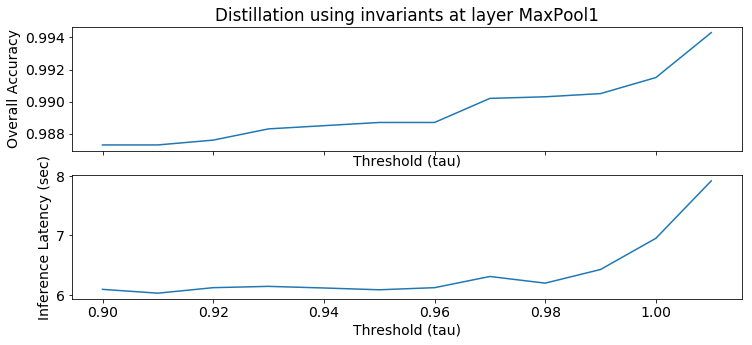

In [0]:
plt.rcParams.update({'font.size': 14})

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,5))
ax1.plot(thresholds, hybrid_accs_maxpool1)
ax1.set_xlabel('Threshold (tau)')
ax1.set_ylabel('Overall Accuracy')

ax2.plot(thresholds, hybrid_times_maxpool1)
ax2.set_ylabel('Inference Latency (sec)')
ax2.set_xlabel('Threshold (tau)')
ax1.set_title('Distillation using invariants at layer MaxPool1')


In [0]:
# Layer MaxPool2
invs_maxpool2 =  get_invariants_with_quality(
  est_maxpool2, validation_suffixes_maxpool2, validation_predictions, min_samples=100)
test_suffixes_maxpool2_ie = test_suffixes_maxpool2

thresholds = 1.0*np.arange(90,102)/100
hybrid_accs_maxpool2 = []
hybrid_times_maxpool2 = []
for t in thresholds:
  invs_map = get_invs_above_thresh(est_maxpool2, invs_maxpool2, t)
  hacc, num_in_inv = get_hybrid_accuracy(
    est_maxpool2, test_suffixes_maxpool2_ie, test_predictions_ie, test_labels_ie, invs_map)
  hybrid_accs_maxpool2.append(hacc)
  times = []
  for _ in range(10):
    latency, num_not_in_inv = test_hybrid_inference(
      est_maxpool2, test_images_ie, t_maxpool2, 1024, invs_map)
    assert num_not_in_inv + num_in_inv == 10000
    times.append(latency)
  htime = np.average(times)
  hybrid_times_maxpool2.append(htime)
  print "Threshold %f: (Acc:%f, Time:%f)" % (t, hacc, htime)

Threshold 0.900000: (Acc:0.990300, Time:6.730468)
Threshold 0.910000: (Acc:0.990300, Time:6.801510)
Threshold 0.920000: (Acc:0.990400, Time:6.747604)
Threshold 0.930000: (Acc:0.990400, Time:6.720746)
Threshold 0.940000: (Acc:0.990500, Time:6.720493)
Threshold 0.950000: (Acc:0.991100, Time:6.720351)
Threshold 0.960000: (Acc:0.991100, Time:6.787710)
Threshold 0.970000: (Acc:0.991100, Time:6.717443)
Threshold 0.980000: (Acc:0.991100, Time:6.712110)
Threshold 0.990000: (Acc:0.991100, Time:6.728770)
Threshold 1.000000: (Acc:0.991400, Time:6.872642)
Threshold 1.010000: (Acc:0.994300, Time:6.822579)


Text(0.5,1,'Distillation using layer MaxPool2 at various thresholds')

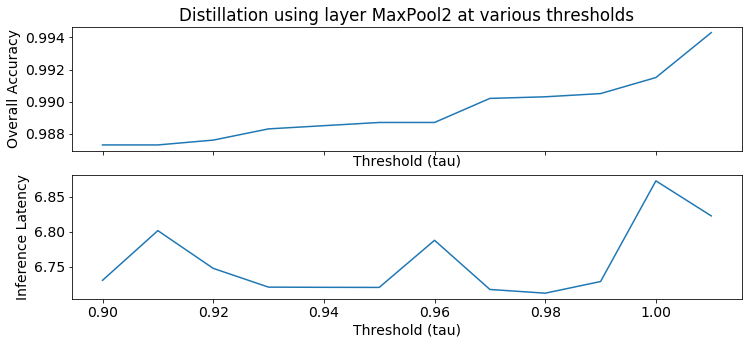

In [0]:
plt.rcParams.update({'font.size': 14})

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,5))
ax1.plot(thresholds, hybrid_accs_maxpool1)
ax1.set_xlabel('Threshold (tau)')
ax1.set_ylabel('Overall Accuracy')

ax2.plot(thresholds, hybrid_times_maxpool2)
ax2.set_ylabel('Inference Latency')
ax2.set_xlabel('Threshold (tau)')
ax1.set_title('Distillation using layer MaxPool2 at various thresholds')


In [0]:
def get_basic_estimator_confidence(estimator, suffixes):
  leaf_nodes = estimator.apply(suffixes)
  conf_score = estimator.tree_.n_node_samples[leaf_nodes]
  # check that the leaf is pure
  is_pure = np.array([ len(np.where(v != 0)[0]) == 1 for v in estimator.tree_.value[leaf_nodes][:,0,:]])
  print "Num pure instances", np.sum(is_pure)
  conf_score *= is_pure
  return conf_score

In [0]:
def plot_bars(ax, bar_vals, bar_names, ptiles, baseline_val=None, baseline_label=None, width=0.2):
  ax.set_ylabel("Hybrid accuracy")
  ax.set_xlabel("Proportion of Examples")
  #ax.set_ylim((min([min(b) for b in bar_vals])-0.05, 1.1))
  # ax.set_title(title)
  # TODO: why 'plt' below and not 'ax'?
  ind = np.arange(len(ptiles))
  ax.set_xticks(ind)
  ax.set_xticklabels(["%d%%"%(100-ptile) for ptile in ptiles])
  if baseline_val != None:
    ax.axhline(y=baseline_val, color='b', linestyle='-', label=baseline_label)
  
  colors = ['red', 'blue', 'yellow', 'green']
  bars = []
  for i, b in enumerate(bar_vals):
    assert len(b) == len(ptiles)
    #bars.append(ax.bar(ind+i*width, b, width=width, color=colors[i]))
    bars.append(ax.plot(b, color=colors[i]))
  ax.legend(bars, bar_names)

In [0]:
import matplotlib.pyplot as plt

def show_hybrid_acc_plot(estimator, suffixes, orig_model_predictions, gt_predictions, ptiles):
  def get_hybrid_acc_at_ptile(score, ptile):
    above_ptile = score >= np.percentile(score, ptile)
    return np.average(estimator_correct*above_ptile) + np.average(orig_correct*(1-above_ptile))
  
  estimator_predictions = estimator.predict(suffixes)
  estimator_correct = (estimator_predictions == gt_predictions)
  orig_correct = (orig_model_predictions == gt_predictions)
  conf_score = get_basic_estimator_confidence(estimator, suffixes)
  
  hybrid_acc_by_conf = []
  for ptile in ptiles:
    hybrid_acc_by_conf.append(get_hybrid_acc_at_ptile(conf_score, ptile))
  fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,5))
  plot_bars(
      ax,
      [hybrid_acc_by_conf],
      ['Hybrid accuracy'],
      ptiles,
  )
  plt.show(fig)

Num pure instances 10000


/usr/local/lib/python2.7/dist-packages/matplotlib/legend.py:937: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f4af45f8dd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


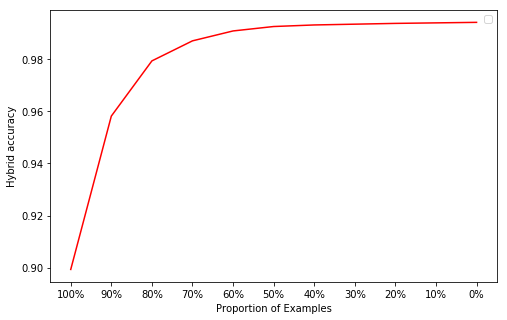

In [0]:
show_hybrid_acc_plot(est_maxpool1, test_suffixes_maxpool1, test_predictions, mnist.test.labels, 10*np.arange(11))

Num pure instances 10000


/usr/local/lib/python2.7/dist-packages/matplotlib/legend.py:937: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f4af690a910>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


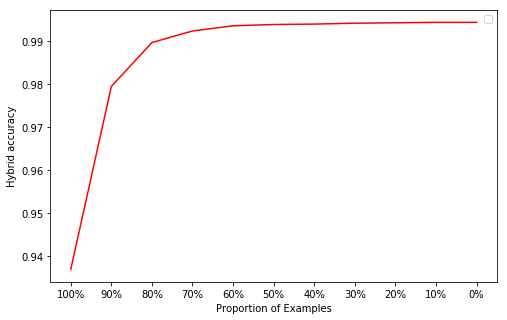

In [0]:
show_hybrid_acc_plot(est_maxpool2, test_suffixes_maxpool2, test_predictions, mnist.test.labels, 10*np.arange(11))

## Examine clusters/invariants

In [0]:
def get_decision_path(estimator, inp):
  # Extract the decision path taken by an input as an ordered list of indices
  # of the neurons that were evaluated.
  # See: http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
  n_nodes = estimator.tree_.node_count
  feature = estimator.tree_.feature

  # First let's retrieve the decision path of each sample. The decision_path
  # method allows to retrieve the node indicator functions. A non zero element of
  # indicator matrix at the position (i, j) indicates that the sample i goes
  # through the node j.
  X_test = [inp]
  node_indicator = estimator.decision_path(X_test)
  # Similarly, we can also have the leaves ids reached by each sample.
  leaf_id = estimator.apply(X_test)
  # Now, it's possible to get the tests that were used to predict a sample or
  # a group of samples. First, let's make it for the sample.
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]
  neuron_ids = []
  for node_id in node_index:
    if leaf_id[0] == node_id:
        continue
    neuron_ids.append(feature[node_id])
  return neuron_ids

def get_suffix_cluster(neuron_ids, neuron_sig):
  # Get the cluster of inputs that such that all inputs in the cluster
  # have provided on/off signature for the provided neurons.
  #
  # The returned cluster is an array of indices (into mnist.train.images).
  return np.where((train_suffixes[:, neuron_ids] == neuron_sig).all(axis=1))[0]

def is_consistent_cluster(cluster, predictions):
  # Check if all inputs within the cluster have the same prediction.
  # 'cluster' is an array of input ids.
  pred = predictions[cluster[0]]
  for i in cluster:
    if predictions[i] != pred:
      return False
  return True

def is_misclassified(i):
  return train_predictions[i] != mnist.train.labels[i]

def visualize_conductances(img, label, neuron_ids, only_on=False):
  # Visualize the conductances for the provided image.
  # Args:
  # - img: the provided mnist image
  # - label: prediction label w.r.t. conductance must be computed
  # - neuron_ids: list of neurons indices from the suffix tensor for which
  #    conductances must be computed.
  # - only_on: If True then conductance is computed only for those neurons
  #    that are on for the given image. 
  vis = [mnist_to_pil_img(img)]
  suffix = fingerprint_suffix([img])
  for i, id in enumerate(neuron_ids):
    if only_on and suffix[i] != 1:
      continue  
    igc = conductance(img, label, neuron_id=id)
    # igc = conductances[id]
    vis.append(visualize_attrs2(255*mnist_to_rgb(img), mnist_to_rgb(igc)))
  return combine(vis)

def get_invariant(estimator, ref_id):
  # Returns an invariant found w.r.t. the provided reference input
  # Args
  #  - ref_id: Index (into mnist.train.images) of the reference input
  # Returns:
  #  - cluster: Indices of training inputs that satisfy the invariant
  #  - neuron_id: A list of neurons such that all inputs that agree with
  #    the reference input on the on/off status of these neurons have the
  #    same prediction as the reference input.
  ref_img = mnist.train.images[ref_id]
  ref_suffix = train_suffixes[ref_id]
  neuron_ids = get_decision_path(estimator, ref_suffix)
  neuron_sig = ref_suffix[neuron_ids]
  cluster = get_suffix_cluster(neuron_ids, neuron_sig)
  return cluster, neuron_ids, neuron_sig

def get_all_invariants(estimator):
  # Returns a dictionary mapping each decision tree prediction class
  # to a list of invariants. Each invariant is specified as a triple:
  # - neuron ids
  # - neuron signature (for the neuron ids)
  # - number of training samples that hit it
  # The neuron ids and neuron signature can be supplied to get_suffix_cluster
  # to obtain the cluster of training instances that hit the invariant.
  def is_leaf(node):
    return estimator.tree_.children_left[node] == estimator.tree_.children_right[node]

  def left_child(node):
    return estimator.tree_.children_left[node]

  def right_child(node):
    return estimator.tree_.children_right[node]
  
  def get_all_paths_rec(node):
    # Returns a list of triples corresponding to paths
    # in the decision tree. Each triple consists of
    # - neurons encountered along the path
    # - signature along the path
    # - prediction class at the leaf
    # - number of training samples that hit the path
    # The prediction class and number of training samples
    # are set to -1 when the leaf is "impure".
    feature = estimator.tree_.feature
    if is_leaf(node):
      values = estimator.tree_.value[node][0]
      if len(np.where(values != 0)[0]) == 1:
        cl = estimator.classes_[np.where(values != 0)[0][0]]
        nsamples = estimator.tree_.n_node_samples[node]
      else:
        print "Found impure leaf at node", node
        # impure node
        cl = -1
        nsamples = np.sum(values)
      return [[[], [], cl, nsamples]]
    # If it is not a leaf both left and right childs must exist
    paths = [[[feature[node]] + p[0], [0] + p[1], p[2], p[3]] for p in get_all_paths_rec(left_child(node))]
    paths += [[[feature[node]] + p[0], [1] + p[1], p[2], p[3]] for p in get_all_paths_rec(right_child(node))]
    return paths
  paths =  get_all_paths_rec(0)
  print "Obtained all paths"
  invariants = {}
  for p in tqdm(paths):
    neuron_ids, neuron_sig, cl, nsamples = p
    if cl not in invariants:
      invariants[cl] = []
    # cluster = get_suffix_cluster(neuron_ids, neuron_sig)
    invariants[cl].append([neuron_ids, neuron_sig, nsamples])
  for cl in invariants.keys():
    invariants[cl] = sorted(invariants[cl], key=operator.itemgetter(2), reverse=True)
  return invariants

def describe_cluster(cluster, neuron_ids, show_samples=False):
  neuron_sig = train_suffixes[cluster[0]][neuron_ids]
  print "Num neurons in invariant", len(neuron_ids)
  print "Neuron id and signature", zip(neuron_ids, neuron_sig)
  print "Cluster size: ", len(cluster)
  print "Num misclassified", len([i for i in cluster if is_misclassified(i)])
  if show_samples:
    for i in range(10):
      images = []
      for j in range(10):
        if 10*i + j >= len(cluster):
          break
        images.append(mnist_to_pil_img(mnist.train.images[cluster[10*i+j]]))
      if len(images) > 0:
        show_img(combine(images))

def describe_all_invariants(all_invariants):
  df = []
  for cl, invs in all_invariants.iteritems():
    # Note the number of invariants, and size of the largest invariant cluster
    df.append([cl, sum([inv[2] for inv in invs]), len(invs), sum([inv[2] for inv in invs if inv[2]<=10]), invs[0][2]])
  df = pd.DataFrame(df, columns=['Prediction Class', 'Num Instances', 'Num Invariants', 'Num Instances in Invariants of size <= 10', 'Size of largest Invariant'])
  return df

In [0]:
# Examine cluster/invariants containing a given reference input
# ref_id is the index of the reference input
ref_id =  3
print "### Reference Image ###"
describe_input(ref_id)
print "### Cluster ###"
cluster, neuron_ids, neuron_sig = get_invariant(basic_estimator, ref_id)
describe_cluster(cluster, neuron_ids, show_samples=True)

# Visualize  10 inputs in the cluster
# for i in cluster[:10]:
  # show_img(visualize_conductances(mnist.train.images[i], train_predictions[i], neuron_ids, only_on=False))

### Reference Image ###
Input 3
Groundtruth 6
Prediction 6
Fine-grained prediction 66


### Cluster ###
Num neurons in invariant 21
Neuron id and signature [(576, 0), (595, 1), (492, 0), (154, 1), (152, 0), (539, 0), (712, 1), (106, 0), (861, 0), (783, 0), (261, 0), (981, 0), (143, 0), (487, 0), (274, 0), (923, 0), (553, 1), (616, 0), (64, 0), (1001, 0), (142, 0)]
Cluster size:  3723
Num misclassified 0


In [0]:
# Get all fine_grained_estimator invariants
be_all_invariants = get_all_invariants(basic_estimator)
#fge_all_invariants = get_all_invariants(fine_grained_estimator)
# Print invariant stats
df = describe_all_invariants(be_all_invariants)
print "Total num invariants:", df['Num Invariants'].sum()
print df.to_string(index=False)



100%|██████████| 3404/3404 [00:00<00:00, 316474.06it/s]

Obtained all paths
Total num invariants: 3404
Prediction Class  Num Instances  Num Invariants  Num Instances in Invariants of size <= 10  Size of largest Invariant
               0           5444             197                                        353                       4145
               1           6180             170                                        353                       4404
               2           5470             371                                        720                       1992
               3           5637             476                                        935                       2025
               4           5303             314                                        622                       2432
               5           4986             434                                        805                       1372
               6           5418             271                                        516                       3261
          

In [0]:
print graph.get_tensor_by_name('activation_2/Relu:0')
print graph.get_tensor_by_name('max_pooling2d_1/MaxPool:0')
print graph.get_tensor_by_name('activation_4/Relu:0')
print graph.get_tensor_by_name('max_pooling2d_2/MaxPool:0')

Tensor("activation_2/Relu:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 12, 12, 32), dtype=float32)
Tensor("activation_4/Relu:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 4, 4, 64), dtype=float32)


In [0]:
# Get all fine_grained_estimator invariants
fge_all_invariants = get_all_invariants(fine_grained_estimator)
#fge_all_invariants = get_all_invariants(fine_grained_estimator)
# Print invariant stats
df = describe_all_invariants(fge_all_invariants)
print "Total num invariants:", df['Num Invariants'].sum()
print "Total num invariants with cluster size >= 10:", df['Num Invariants with cluster size >= 10'].sum()
print df.to_string(index=False)

100%|██████████| 2186/2186 [00:00<00:00, 212771.48it/s]

Obtained all paths
Total num invariants: 2186
Total num invariants with cluster size >= 10: 329
Prediction Class  Num Instances  Num Invariants  Num Invariants with cluster size >= 10  Size of largest invariant cluster
               0           5444             120                                      22                               4494
              33           5637             266                                      32                               3847
              66           5417             161                                      28                               3723
              99           5453             237                                      38                               3040
              98              1               1                                       0                                  1
              17              1               1                                       0                                  1
              11           6178            

### Analyzing clusters of misclassified inputs

In [0]:
# Examine the cluster for a misclasification (Groundtruth: 4, Prediction: 49)
invs = fge_all_invariants[49]
neuron_ids, neuron_sig, _ = invs[0]
cluster = get_suffix_cluster(neuron_ids, neuron_sig)
describe_cluster(cluster, neuron_ids)

# Visualize  10 inputs in the cluster
for i in cluster[:10]:
  describe_input(i)
  # show_img(visualize_conductances(mnist.train.images[i], train_predictions[i], neuron_ids, only_on=False))

Num neurons in invariant 16
Neuron id and signature [(483, 0), (81, 1), (833, 1), (478, 0), (840, 1), (649, 1), (79, 1), (626, 0), (654, 1), (803, 0), (534, 1), (754, 0), (994, 1), (805, 0), (850, 1), (55, 1)]
Cluster size:  3
Num misclassified 3
Input 4958
Groundtruth 4
Prediction 9
Fine-grained prediction 49


Input 14434
Groundtruth 4
Prediction 9
Fine-grained prediction 49


Input 54692
Groundtruth 4
Prediction 9
Fine-grained prediction 49


## Test Accuracy Improvements

In [0]:
def get_estimator_confidence(
    estimator, suffixes, estimator_predictions,
    estimator_leaf_nodes, estimator_conf_labels):
  # The confidence for each input is the number of samples that visit the same
  # leaf as the input. The exception is inputs that reach impure leaves or leaves
  # with labels outside estimator_conf_labels. For them the confidence is 0. 
  #
  # Compute number of samples that visit the leaves
  estimator_conf = estimator.tree_.n_node_samples[estimator_leaf_nodes]
  # check that the leaf has valid label. (For instance, for a fine grained estimator
  # only labels 00, 11, .. are valid.)
  estimator_conf *= np.array([p in estimator_conf_labels for p in estimator_predictions])
  # check that the leaf is pure
  estimator_conf *= (estimator.tree_.impurity[estimator_leaf_nodes] == 0.0)
  return estimator_conf

def get_confident_accuracy(
    estimator, suffixes, orig_model_predictions,
    gt_labels, estimator_conf_labels, min_samples=10):
  """
  Args:
    estimator: the estimator used for confidence modeling
    suffixes: the suffixes of the examples over which we evaluate. Typically this
      would be 'test_suffixes'.
    orig_model_predictions: predictions of the original model for these examples. 
      Typically this would be 'test_predictions'.
    gt_labels: groundtruth labels for these examples. Typically this would be
      mnist.test.labels.
    estimator_conf_labels: prediction labels for the estimator which must be used
      for confidence labels. If the estimator predicts a label outside this set then
      the prediction on the example is not considered "confident". For the basic_estimator
      all labels are fine for confidence modeling. For the fine_grained estimator
      we would want to only use the "pure" labels for confident modeling. For
      instance, 00, 11, ... , for the MNIST fine_grained_estimator.
    min_samples: minimum number of samples for an estimator leaf for it to be
      considered confident
  """
  estimator_predictions = estimator.predict(suffixes)
  estimator_leaf_nodes = estimator.apply(suffixes)

  # The following are all binary vectors of shape <len(suffixes)>  
  orig_correct = (orig_model_predictions == gt_labels)
  estimator_conf = get_estimator_confidence(
      estimator, suffixes, estimator_predictions, estimator_leaf_nodes,
      estimator_conf_labels)
  
  estimator_conf = estimator_conf > min_samples
  conf_frac = 1.0*np.sum(estimator_conf)/len(suffixes)
  overall_acc = 1.0*np.sum(orig_correct)/len(suffixes)
  conf_acc = 1.0*np.sum(orig_correct*estimator_conf)/np.sum(estimator_conf)
 
  return conf_frac, overall_acc, conf_acc

def get_confident_agreement(
    estimator, suffixes, orig_model_predictions,
    gt_labels, estimator_conf_labels, min_samples=10):
  """
  Args:
    estimator: the estimator used for confidence modeling
    suffixes: the suffixes of the examples over which we evaluate. Typically this
      would be 'test_suffixes'.
    orig_model_predictions: predictions of the original model for these examples. 
      Typically this would be 'test_predictions'.
    gt_labels: groundtruth labels for these examples. Typically this would be
      mnist.test.labels.
    estimator_conf_labels: prediction labels for the estimator which must be used
      for confidence labels. If the estimator predicts a label outside this set then
      the prediction on the example is not considered "confident". For the basic_estimator
      all labels are fine for confidence modeling. For the fine_grained estimator
      we would want to only use the "pure" labels for confident modeling. For
      instance, 00, 11, ... , for the MNIST fine_grained_estimator.
    min_samples: minimum number of samples for an estimator leaf for it to be
      considered confident
  """
  estimator_predictions = estimator.predict(suffixes)
  estimator_leaf_nodes = estimator.apply(suffixes)

  # The following are all binary vectors of shape <len(suffixes)>  
  orig_correct = (orig_model_predictions == gt_labels)
  estimator_conf = get_estimator_confidence(estimator, suffixes, estimator_predictions,
      estimator_leaf_nodes, estimator_conf_labels)
  estimator_conf = estimator_conf > min_samples

  estimator_agreement = (estimator_predictions == orig_model_predictions)
  conf_frac = 1.0*np.sum(estimator_conf)/len(suffixes)
  overall_agreement = 1.0*np.sum(estimator_agreement)/len(suffixes)
  conf_agreement = 1.0*np.sum(estimator_agreement*estimator_conf)/np.sum(estimator_conf)
 
  return conf_frac, overall_agreement, conf_agreement

In [0]:
estimator_predictions = basic_estimator.predict(test_suffixes)
estimator_leaf_nodes = basic_estimator.apply(test_suffixes)

gt = mnist.test.labels
estimator_leaf_num_samples = get_estimator_confidence(
    basic_estimator, test_suffixes,
    estimator_predictions, estimator_leaf_nodes, np.array(range(10)))

orig_correct = (test_predictions == gt)
estimator_correct = (estimator_predictions == gt)
estimator_agreement = (estimator_predictions == test_predictions)

min_samples = 2000
estimator_conf = estimator_leaf_num_samples > min_samples

print "ORIGINAL MODEL under BASIC ESTIMATOR (min_samples = %d)" % min_samples
print "Overall Acc", 1.0*np.mean(orig_correct)
print "Confident fraction", 1.0*np.mean(estimator_conf)
print "Confident Acc", 1.0*np.sum(orig_correct*estimator_conf)/np.sum(estimator_conf)

print ""
print "BASIC ESTIMATOR"
print "Acc", np.mean(estimator_correct)
print "Agreement", np.mean(estimator_agreement)
print "Estimator Confident Acc", 1.0*np.sum(estimator_correct*estimator_conf)/np.sum(estimator_conf)
print "Estimator Confident Agreement", 1.0*np.sum(estimator_agreement*estimator_conf)/np.sum(estimator_conf)
print "Combined Acc", 1.0*np.mean(orig_correct*(1-estimator_conf)) + 1.0*np.mean(estimator_correct*estimator_conf)

ORIGINAL MODEL under BASIC ESTIMATOR (min_samples = 2000)
Overall Acc 0.9943
Confident fraction 0.3911
Confident Acc 0.999488621836

BASIC ESTIMATOR
Acc 0.8986
Agreement 0.899
Estimator Confident Acc 0.994886218358
Estimator Confident Agreement 0.994630529276
Combined Acc 0.9925


In [0]:
# FINE_GRAINED_ESTIMATOR
res = get_confident_accuracy(
    fine_grained_estimator, test_suffixes, 
    test_predictions, mnist.test.labels,
    10*np.array(range(10))+np.array(range(10)), min_samples = 5)
conf_frac, overall_acc,  conf_acc = res

print "ORIGINAL MODEL under FINE GRAINED ESTIMATOR"
print "Confident fraction", conf_frac
print "Confident accuracy", conf_acc

ORIGINAL MODEL under FINE GRAINED ESTIMATOR
Confident fraction 0.8507
Confident accuracy 0.996355942165


## Inference Speedup Experiment

In [0]:
def test_eval_with_estimator(images):
  t_decision_layer = graph.get_tensor_by_name('max_pooling2d_1/MaxPool:0')
  layer_predictions = get_prediction2(t_image, images, t_decision_layer)
  suffixes = (np.reshape(layer_predictions, [-1, 4608]) > 0.0).astype('int')
  estimator_predictions = basic_estimator.predict(suffixes)
  estimator_leaf_nodes = basic_estimator.apply(suffixes)
  non_conf_indices = np.where(basic_estimator.tree_.n_node_samples[estimator_leaf_nodes] < 500)[0]
  get_prediction2(t_decision_layer, layer_predictions[non_conf_indices], t_prediction)

cProfile.run("test_eval_with_estimator(reshaped_test_images)")

100%|██████████| 45/45 [00:01<00:00, 41.97it/s]


         52588 function calls (52008 primitive calls) in 6.526 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.008    0.004    6.100    3.050 <ipython-input-426-431e42223bfd>:16(get_prediction2)
      145    0.002    0.000    5.907    0.041 <ipython-input-426-431e42223bfd>:17(get_prediction_batch)
        1    0.087    0.087    6.502    6.502 <ipython-input-451-1242c22687a8>:1(test_eval_with_estimator)
        1    0.023    0.023    6.526    6.526 <string>:1(<module>)
      145    0.000    0.000    0.001    0.000 <string>:8(__new__)
        2    0.000    0.000    0.000    0.000 UserDict.py:35(__getitem__)
        2    0.000    0.000    0.000    0.000 __init__.py:29(get_config)
        2    0.000    0.000    0.045    0.023 _methods.py:31(_sum)
        2    0.000    0.000    0.001    0.000 _monitor.py:32(__init__)
        2    0.000    0.000    0.015    0.007 _monitor.py:50(exit)
        2    0.000    0.000    

In [0]:
reshaped_test_images = np.reshape(mnist.test.images, [len(mnist.test.images), 28, 28, 1])
cProfile.run("get_prediction2(t_image, reshaped_test_images, t_prediction)")

100%|██████████| 100/100 [00:07<00:00, 13.78it/s]


         37565 function calls (37165 primitive calls) in 7.258 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.004    0.004    7.258    7.258 <ipython-input-426-431e42223bfd>:16(get_prediction2)
      100    0.001    0.000    7.123    0.071 <ipython-input-426-431e42223bfd>:17(get_prediction_batch)
        1    0.000    0.000    7.258    7.258 <string>:1(<module>)
      100    0.000    0.000    0.000    0.000 <string>:8(__new__)
        1    0.000    0.000    0.000    0.000 UserDict.py:35(__getitem__)
        1    0.000    0.000    0.007    0.007 _monitor.py:32(__init__)
        1    0.000    0.000    0.039    0.039 _monitor.py:50(exit)
        1    0.000    0.000    0.000    0.000 _monitor.py:97(report)
       55    0.000    0.000    0.002    0.000 _tqdm.py:101(release)
       55    0.000    0.000    0.002    0.000 _tqdm.py:105(__enter__)
       55    0.000    0.000    0.002    0.000 _tqdm.py:108(__exit__)
  

## Detecting adversarial examples

In [0]:
# Load examples from feature squeezing paper
!mkdir results
!curl -sL https://github.com/mzweilin/EvadeML-Zoo/releases/download/v0.1/results_MNIST_100_317f6_carlini.tar.gz | tar xzv -C results


MNIST_100_317f6_carlini/
MNIST_100_317f6_carlini/adv_examples/
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_jsma?targeted=next.pickle
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_carlinili?targeted=next&batch_size=1&max_iterations=1000&confidence=10.pickle
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_bim?eps=0.3&eps_iter=0.06.pickle
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_adaptive_carlini_l2?targeted=next&tf_squeezers=median_filter_2_2,binary_filter_0.5&distance_measure=l1&detector_threshold=0.002915.pickle
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_carlinil0?targeted=next&batch_size=1&max_iterations=1000&confidence=10.pickle
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_adaptive_carlini_l2?targeted=false&tf_squeezers=median_filter_2_2,binary_filter_0.5&distance_measure=l1&detector_threshold=0.002915.pickle
MNIST_100_317f6_carlini/adv_examples/MNIST_100_317f6_carlini_fgsm?eps=0.3.pickl

In [0]:
import h5py
import cPickle

# We discard adaptive adversaries
attack_paths = [
  #'MNIST_100_317f6_carlini_adaptive_carlini_l2?targeted=false&tf_squeezers=median_filter_2_2,binary_filter_0.5&distance_measure=l1&detector_threshold=0.002915.pickle',
  #'MNIST_100_317f6_carlini_adaptive_carlini_l2?targeted=ll&tf_squeezers=median_filter_2_2,binary_filter_0.5&distance_measure=l1&detector_threshold=0.002915.pickle',
  #'MNIST_100_317f6_carlini_adaptive_carlini_l2?targeted=next&tf_squeezers=median_filter_2_2,binary_filter_0.5&distance_measure=l1&detector_threshold=0.002915.pickle',
  'MNIST_100_317f6_carlini_bim?eps=0.3&eps_iter=0.06.pickle',
  'MNIST_100_317f6_carlini_carlinil0?targeted=ll&batch_size=1&max_iterations=1000&confidence=10.pickle',
  'MNIST_100_317f6_carlini_carlinil0?targeted=next&batch_size=1&max_iterations=1000&confidence=10.pickle',
  'MNIST_100_317f6_carlini_carlinil2?targeted=ll&batch_size=100&max_iterations=1000&confidence=10.pickle',
  'MNIST_100_317f6_carlini_carlinil2?targeted=next&batch_size=100&max_iterations=1000&confidence=10.pickle',
  'MNIST_100_317f6_carlini_carlinili?targeted=ll&batch_size=1&max_iterations=1000&confidence=10.pickle',
  'MNIST_100_317f6_carlini_carlinili?targeted=next&batch_size=1&max_iterations=1000&confidence=10.pickle',
  'MNIST_100_317f6_carlini_fgsm?eps=0.3.pickle',
  'MNIST_100_317f6_carlini_jsma?targeted=ll.pickle',
  'MNIST_100_317f6_carlini_jsma?targeted=next.pickle'
]

attack_dir_name = 'results/MNIST_100_317f6_carlini/adv_examples'
attack_paths = [os.path.join(attack_dir_name, p) for p in attack_paths]

all_attacks = []
for p in attack_paths:
  all_attacks.append(cPickle.load(open(p))[0])
all_attacks = np.concatenate(tuple(all_attacks), axis=0)
all_attacks = np.reshape(all_attacks, [all_attacks.shape[0], -1])

In [0]:
ind = np.array(range(10000))
np.random.shuffle(ind)

In [0]:
all_attacks_predictions = np.argmax(get_prediction(all_attacks), axis=1)
all_attacks_gt = np.concatenate(tuple([mnist.test.labels[:100] for _ in range(10)]), axis=0)
print "Attack succcess rate", 1.0*np.sum(all_attacks_gt != all_attacks_predictions)/len(all_attacks)
successful_attacks = all_attacks[np.where(all_attacks_predictions != all_attacks_gt)[0]]

benign_suffixes = test_suffixes[ind]
successful_attacks_suffixes = fingerprint_suffix(successful_attacks)

  0%|          | 0/9 [00:00<?, ?it/s]

Attack succcess rate 0.87
Getting fingerprint for Reshape_7:0


100%|██████████| 9/9 [00:00<00:00, 53.71it/s]


In [0]:
benign_be_predictions = basic_estimator.predict(benign_suffixes)
benign_be_leaf_nodes = basic_estimator.apply(benign_suffixes)
benign_be_conf = get_estimator_confidence(
    basic_estimator, benign_suffixes, benign_be_predictions, benign_be_leaf_nodes,
    range(10)
)

benign_fge_predictions = fine_grained_estimator.predict(benign_suffixes)
benign_fge_leaf_nodes = fine_grained_estimator.apply(benign_suffixes)
benign_fge_conf = get_estimator_confidence(
    fine_grained_estimator, benign_suffixes, benign_fge_predictions, benign_fge_leaf_nodes,
    11*np.array(range(10))
)

successful_attacks_be_predictions = basic_estimator.predict(successful_attacks_suffixes)
successful_attacks_be_leaf_nodes = basic_estimator.apply(successful_attacks_suffixes)
successful_attacks_be_conf = get_estimator_confidence(
    basic_estimator, successful_attacks_suffixes, successful_attacks_be_predictions,
    successful_attacks_be_leaf_nodes, np.array(range(10)))

successful_attacks_fge_predictions = fine_grained_estimator.predict(successful_attacks_suffixes)
successful_attacks_fge_leaf_nodes = fine_grained_estimator.apply(successful_attacks_suffixes)
successful_attacks_fge_conf = get_estimator_confidence(
    fine_grained_estimator, successful_attacks_suffixes, successful_attacks_fge_predictions,
    successful_attacks_fge_leaf_nodes, 11*np.array(range(10)))

print "Num successful attacks", len(successful_attacks)
print "Fraction of successful attacks in low-density (size < 10) clusters", 1.0*np.mean(successful_attacks_be_conf <10)
print "Fraction of benign inputs in low-density (size < 10) clusters", 1.0*np.mean(benign_be_conf < 10)


print "Fraction of successful attacks in low-density (size < 100) clusters", 1.0*np.mean(successful_attacks_be_conf < 100)
print "Fraction of benign inputs in low-density (size < 100) clusters", 1.0*np.mean(benign_be_conf < 100)


Num successful attacks 870
Fraction of successful attacks in low-density (size < 10) clusters 0.49310344827586206
Fraction of benign inputs in low-density (size < 10) clusters 0.109
Fraction of successful attacks in low-density (size < 100) clusters 0.8459770114942529
Fraction of benign inputs in low-density (size < 100) clusters 0.2875


In [0]:
np.mean(successful_attacks_be_conf > 1000)

0.03218390804597701

([<matplotlib.axis.XTick at 0x7f6da3b4bc10>,
 <a list of 20 Text xticklabel objects>)

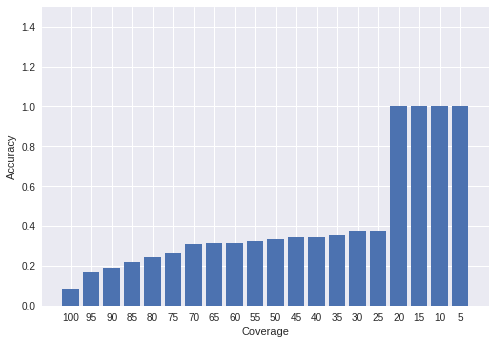

In [0]:
def get_precision_by_coverage(probs, targets, npoints=10):
  # 'targets' is binary and probs is probability for the positive class.
  # 'targets' and 'probs' must have the same shape (of the form <batch>)
  precisions, recalls, thresholds = metrics.precision_recall_curve(targets, probs)
  cutoffs = [np.where(recalls < 1.0*i/npoints)[0][0] for i in range(npoints, 0, -1)]
  thresholds = np.concatenate((thresholds, [10000]), axis=0)
  return precisions[cutoffs], thresholds[cutoffs]

npoints = 20
precisions, thresholds = get_precision_by_coverage(
  (0.0-np.concatenate((benign_be_conf, successful_attacks_be_conf), axis=0)),
  np.concatenate((np.zeros(benign_be_conf.shape), np.ones(successful_attacks_be_conf.shape))),
  npoints
)
plt.bar(np.arange(npoints), precisions)
plt.ylabel("Accuracy")
plt.xlabel("Coverage")
plt.ylim((0.0, 1.5))
plt.xticks(ind, [100-i*int(100/npoints) for i in range(npoints)])

In [0]:
from sklearn import metrics
def get_detection_error_rates(
    benign_conf, attacks_conf, min_samples):
  benign_conf = benign_conf > min_samples
  attacks_conf = attacks_conf > min_samples
  fpr = np.mean(1.0 - benign_conf)
  tpr = np.mean(1.0 - attacks_conf)
  return fpr, tpr

def get_detection_auc(
    benign_conf, attacks_conf):
  fprs = []
  tprs = []
  for min_samples in tqdm(range(1+max(benign_conf.max(), attacks_conf.max()))):
    fpr, tpr = get_detection_error_rates(benign_conf, attacks_conf, min_samples)
    fprs.append(fpr)
    tprs.append(tpr)
  return metrics.auc(fprs, tprs)

In [0]:
min_samples = 10
fpr, tpr = get_detection_error_rates(
  benign_be_conf, successful_attacks_be_conf, min_samples)
print "Basic Estimator (min_samples = %d)" % min_samples
print "FPR (<num test non-confident instances>/ <num test instances>", fpr
print "TPR (<num attack non-confident instances>/ <num attack instances>", tpr

auc = get_detection_auc(
  benign_be_conf, successful_attacks_be_conf)
print "AUC", auc

100%|██████████| 4405/4405 [00:00<00:00, 25918.62it/s]

Basic Estimator (min_samples = 10)
FPR (<num test non-confident instances>/ <num test instances> 0.11149425287356322
TPR (<num attack non-confident instances>/ <num attack instances> 0.4954022988505747
AUC 0.8171488968159598


In [0]:
min_samples = 10
fpr, tpr = get_detection_error_rates(
  benign_fge_conf, successful_attacks_fge_conf, min_samples)
print "Fine-grained Estimator (min_samples = %d)" % min_samples
print "FPR (<num test non-confident instances>/ <num test instances>", fpr
print "TPR (<num attack non-confident instances>/ <num attack instances>", tpr

auc = get_detection_auc(
  benign_fge_conf, successful_attacks_fge_conf)
print "AUC", auc

100%|██████████| 3061/3061 [00:00<00:00, 26910.57it/s]

Fine-grained Estimator (min_samples = 10)
FPR (<num test non-confident instances>/ <num test instances> 0.2149425287356322
TPR (<num attack non-confident instances>/ <num attack instances> 0.7632183908045977
AUC 0.8390335579336768


### Visualizing the Decision Tree

In [0]:
!apt-get install graphviz
!pip install graphviz
import graphviz

In [0]:
dot_data = tree.export_graphviz(basic_estimator, out_file=None) 
graph = graphviz.Source(dot_data)  
graph 